# Deep Learning Methods for Medical Image Analysis (CM2003)

# Laboratory Assignment 2

Lab Group 8:
- Gnana Spandana Akumalla
- Patrik Svensson
- Serkan Arda Yilal

## Deeper Networks

In [1]:
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot as plt

In [2]:
def gen_labels(im_name, pat1, pat2):
    '''
    Parameters
    ----------
    im_name : Str
    The image file name.
    pat1 : Str
    A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
    A string pattern in the filename 2nd class, e.g, "Nev"
    Returns
    -------
    Label : Numpy array
    Class label of the filename name based on its pattern.
    '''
    if pat1 in im_name:
        label = np.array([0])
    elif pat2 in im_name:
        label = np.array([1])
    return label

def get_data(data_path, data_list, img_h, img_w):
    """

    Parameters
    ----------
    train_data_path : Str
    Path to the data directory
    train_list : List
    A list containing the name of the images.
    img_h : Int
    image height to be resized to.
    img_w : Int
    image width to be resized to.
    Returns
    -------
    img_labels : Nested List
    A nested list containing the loaded images along with their
    correcponding labels.
    """
    img_labels = []

    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], 'Mel', 'Nev')])

        if item[0] % 100 == 0:
            print('Reading: {0}/{1} of train images'.format(item[0], len(data_list)))

    shuffle(img_labels)

    return img_labels

def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
    nested list of image arrays with corresponding class labels.
    img_h : Int
    Image height.
    img_w : Int
    Image width.
    Returns
    -------
    img_arrays : Numpy array
    4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
    1D array with the size (n_data).
    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    img_arrays = np.expand_dims(img_arrays, axis =3)
    return img_arrays, label_arrays

def get_train_test_arrays(train_data_path, test_data_path, train_list,
test_list, img_h, img_w):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """
    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)
    
    train_img, train_label = get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

### Functions for model training and plotting

In [3]:
def model_trainer(learning_rate, epochs, n_base, batch_size, dropout = None, 
                  loss = "BinaryCrossentropy", optimizer = "Adam",verbose = 1):
    clf = model(img_w, img_h, 1, n_base, dropout = dropout)

    if optimizer == "Adam":
        
        clf.compile(loss=loss, optimizer = Adam(learning_rate = learning_rate), metrics=['binary_accuracy']) 
        clf_hist = clf.fit(x_train, y_train, shuffle=True, epochs = epochs, batch_size=batch_size, verbose=verbose, 
                       validation_data=(x_test, y_test))
        
    elif optimizer == "SGD":
        
        clf.compile(loss=loss, optimizer = SGD(learning_rate = learning_rate), metrics=['binary_accuracy']) 
        clf_hist = clf.fit(x_train, y_train, shuffle=True, epochs = epochs, batch_size=batch_size, verbose=verbose, 
                       validation_data=(x_test, y_test))    
    
    elif optimizer == "RMSprop":
        
        clf.compile(loss=loss, optimizer = RMSprop(learning_rate = learning_rate), metrics=['binary_accuracy']) 
        clf_hist = clf.fit(x_train, y_train, shuffle=True, epochs = epochs, batch_size=batch_size, verbose=verbose, 
                       validation_data=(x_test, y_test))    
    

    return clf_hist



def loss_accuracy_plot(clf_hist, string):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    #Plot for loss values
    axs[0].set_title("Learning curve")
    axs[0].plot(clf_hist.history["loss"], label="loss")
    axs[0].plot(clf_hist.history["val_loss"], label="val_loss")
    axs[0].plot( np.argmin(clf_hist.history["val_loss"]),
                np.min(clf_hist.history["val_loss"]),
                marker="x", color="r", label="best model")

    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss Value")
    axs[0].legend()
    
    fig.suptitle(string, fontsize=13)
    
    #Plot for accuracy values
    axs[1].set_title("Learning curve")
    axs[1].plot(clf_hist.history["binary_accuracy"], label="accuracy")
    axs[1].plot(clf_hist.history["val_binary_accuracy"], label="val_accuracy")
    axs[1].plot( np.argmax(clf_hist.history["val_binary_accuracy"]),
                np.max(clf_hist.history["val_binary_accuracy"]),
                marker="x", color="r", label="best model")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    plt.show()
    
    
    

In [4]:
img_w, img_h = 128, 128 # Setting the width and heights of the images.
data_path = 'Data/DL_course/Lab1/Skin/' # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')

train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)

x_train, x_test, y_train, y_test = get_train_test_arrays(
    train_data_path, test_data_path,
    train_list, test_list, img_h, img_w)

#When using hinge instead of BinaryCrossEntropy as loss function 
#y_test[y_test == 0] = -1
#y_train[y_train == 0] = -1

Reading: 0/1000 of train images
Reading: 100/1000 of train images
Reading: 200/1000 of train images
Reading: 300/1000 of train images
Reading: 400/1000 of train images
Reading: 500/1000 of train images
Reading: 600/1000 of train images
Reading: 700/1000 of train images
Reading: 800/1000 of train images
Reading: 900/1000 of train images
Reading: 0/200 of train images
Reading: 100/200 of train images


In [5]:
def model(img_width, img_height, img_ch, n_base, dropout = None):
   
    model1 = Sequential()
    
    model1.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch), kernel_size=(3,3),
    strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(2,2)))
   
    model1.add(Conv2D(filters= n_base *2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(2,2)))
    
    model1.add(Conv2D(filters= n_base *4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    
    model1.add(Conv2D(filters= n_base *4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    
    model1.add(Conv2D(filters= n_base *2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(2,2)))
    
    model1.add(Flatten())
    model1.add(Dense(128))
    if isinstance(dropout, float):
        model1.add(Dropout(0.4))
    model1.add(Activation('relu'))
    
    model1.add(Dense(64))
    if isinstance(dropout, float):
        model1.add(Dropout(0.4))
    model1.add(Activation('relu'))
    
    model1.add(Dense(1))
    if isinstance(dropout, float):
        model1.add(Dropout(0.4))
    model1.add(Activation('sigmoid'))
    
    model1.summary()
    
    return model1

### Task 6A

In [7]:
learning_rate = 0.0001
epochs = 50
n_base = 32
batch_size = 8
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size, optimizer = optimizer,verbose = 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

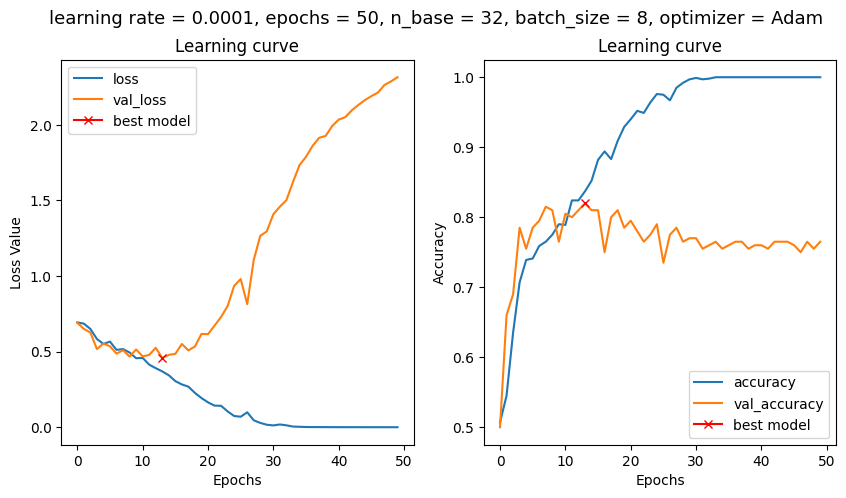

In [9]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, optimizer))

### Task 6B

In [10]:
learning_rate = 0.0001
epochs = 50
n_base = 16
batch_size = 8
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size, optimizer = optimizer,verbose = 0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 activation_8 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 activation_9 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

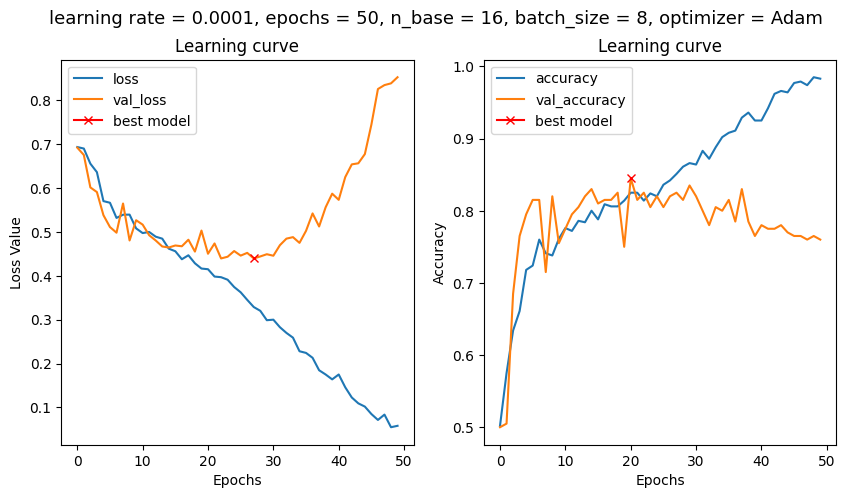

In [11]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, optimizer))

In [12]:
learning_rate = 0.0001
epochs = 50
n_base = 8
batch_size = 8
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size, optimizer = optimizer,verbose = 0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_16 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_17 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                  

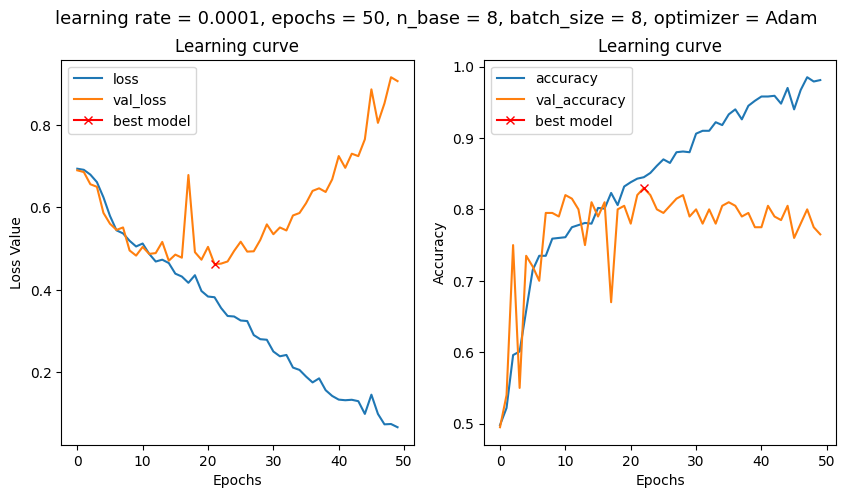

In [13]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, optimizer))

In [14]:
learning_rate = 0.0001
epochs = 50
n_base = 8
batch_size = 8
optimizer = "Adam"
dropout = 0.4

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size, dropout, optimizer = optimizer,verbose = 0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_24 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_25 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                 

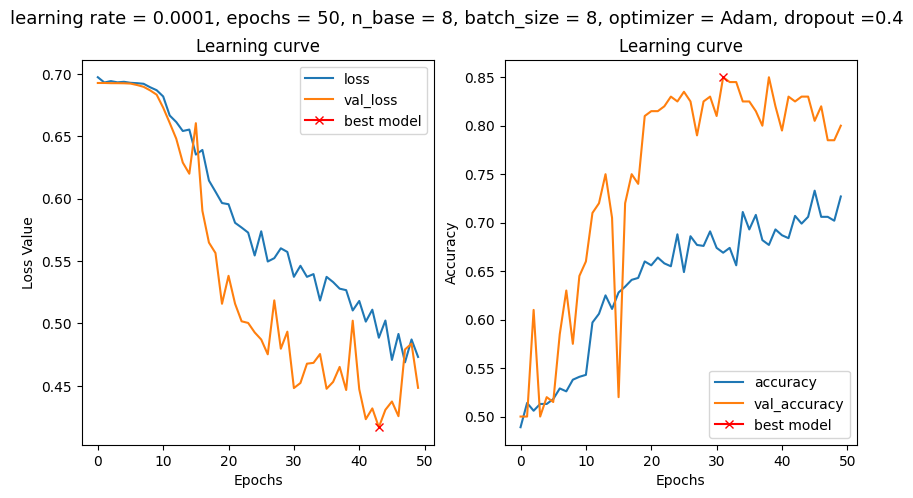

In [15]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}, dropout ={}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer, dropout))

In [16]:
learning_rate = 0.0001
epochs = 150
n_base = 8
batch_size = 8
optimizer = "Adam"
dropout = 0.4

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size, dropout, optimizer = optimizer,verbose = 0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_32 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_33 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                 

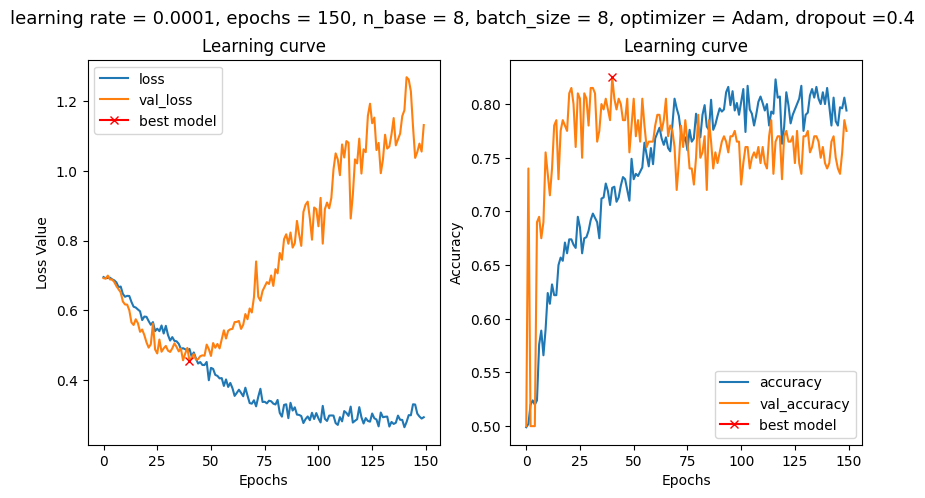

In [17]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}, dropout ={}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer, dropout))

### Task 6C

In [18]:
learning_rate = 1e-5
epochs = 150
n_base = 8
batch_size = 8
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size,  optimizer = optimizer,verbose = 0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_40 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_41 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                 

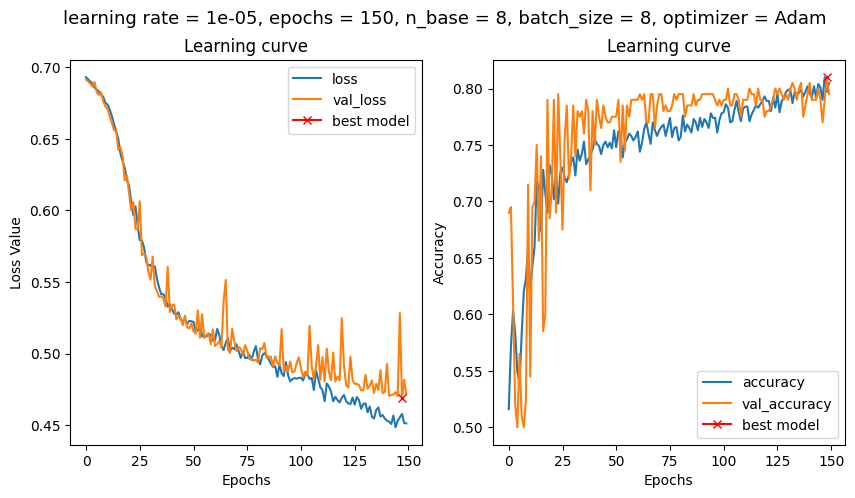

In [19]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer))

In [20]:
learning_rate = 1e-5
epochs = 350
n_base = 8
batch_size = 8
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size,  optimizer = optimizer,verbose = 0)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_48 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_49 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                 

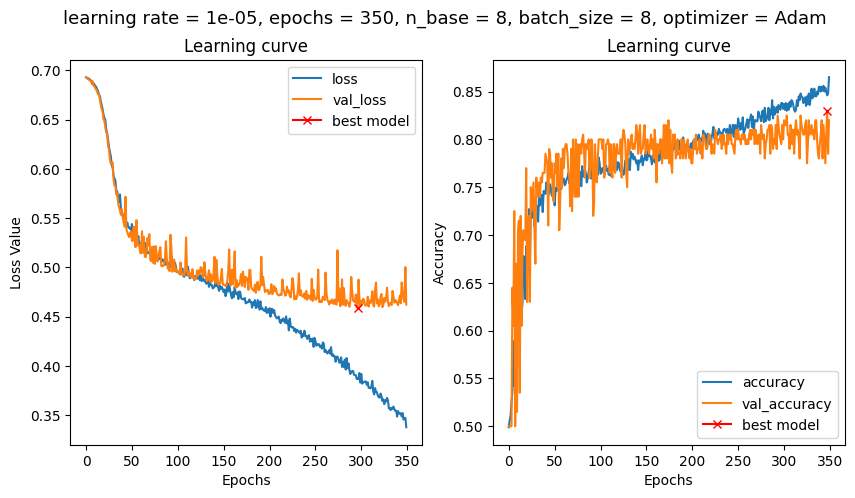

In [21]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer))

### Task 6D

In [30]:
learning_rate = 1e-5
epochs = 150
n_base = 8
batch_size = 2
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size,  optimizer = optimizer,verbose = 0)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_80 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_81 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                

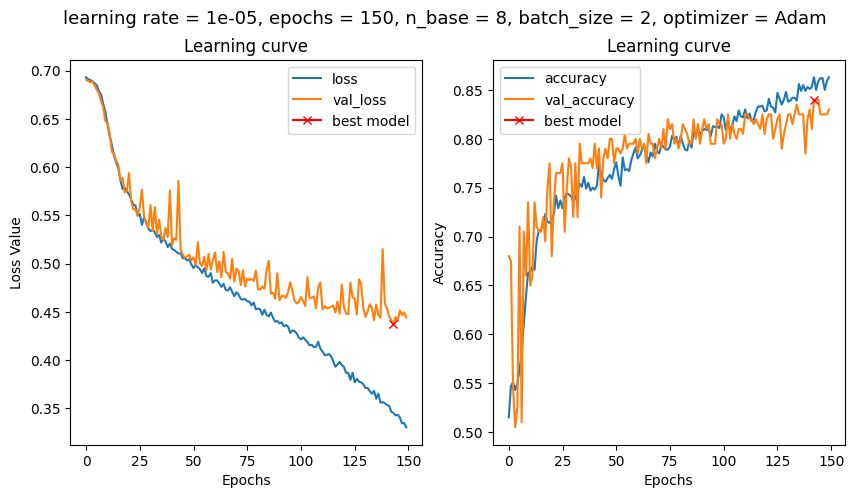

In [31]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer))

In [32]:
learning_rate = 1e-5
epochs = 150
n_base = 8
batch_size = 4
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size,  optimizer = optimizer,verbose = 0)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_88 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_89 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                

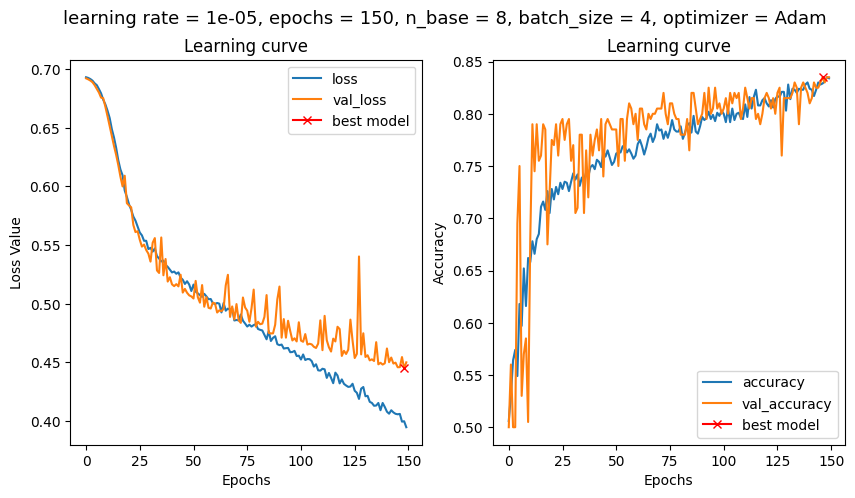

In [33]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer))

In [7]:
learning_rate = 1e-5
epochs = 150
n_base = 8
batch_size = 8
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size,  optimizer = optimizer,verbose = 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       80        
                                                                 
 activation (Activation)     (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                    

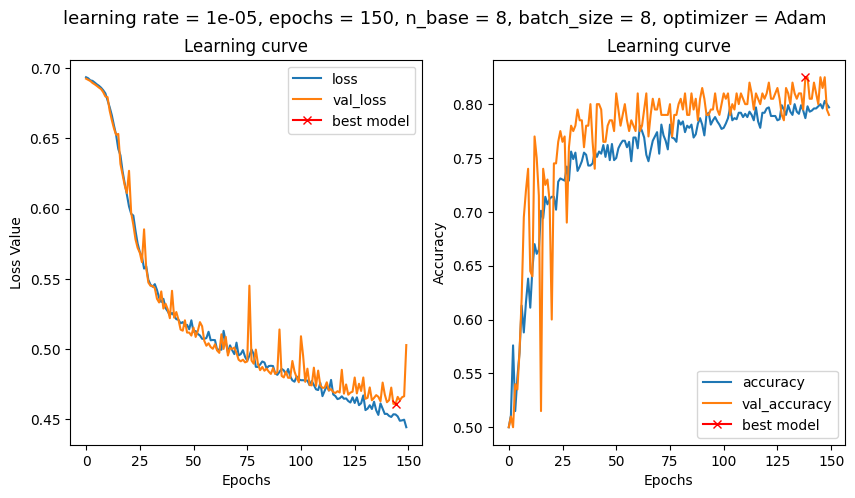

In [8]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer))

### Task 6E

In [6]:
epochs = 100

#optimum values
learning_rate = 1e-5
n_base = 8
batch_size = 4
optimizer = "Adam"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size,  optimizer = optimizer,verbose = 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       80        
                                                                 
 activation (Activation)     (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                    

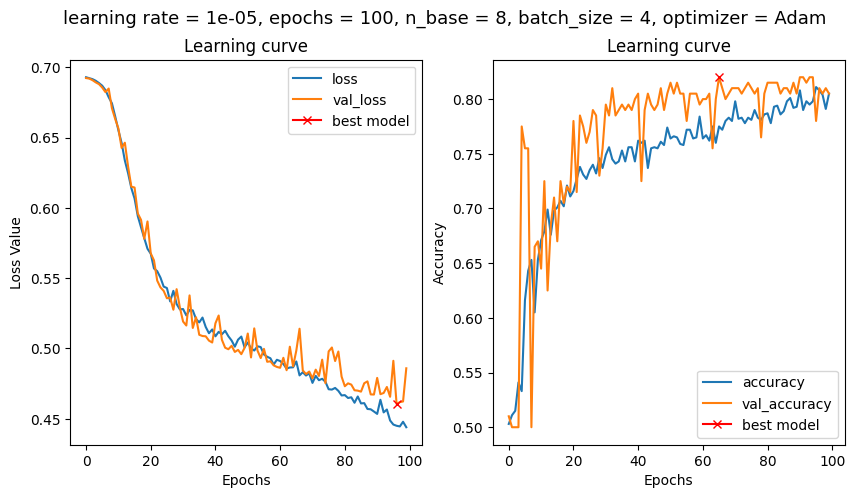

In [7]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer))

In [12]:
epochs = 100

#optimum values
learning_rate = 1e-5
n_base = 8
batch_size = 4
optimizer = "SGD"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size,  optimizer = optimizer,verbose = 0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_24 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_25 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                 

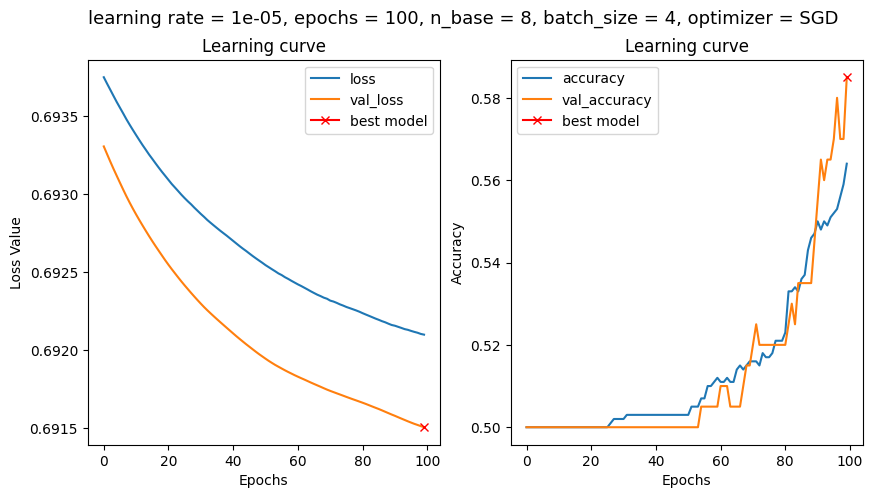

In [13]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer))

In [14]:
epochs = 100

#optimum values
learning_rate = 1e-5
n_base = 8
batch_size = 4
optimizer = "RMSprop"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size,  optimizer = optimizer,verbose = 0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_32 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_33 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                 

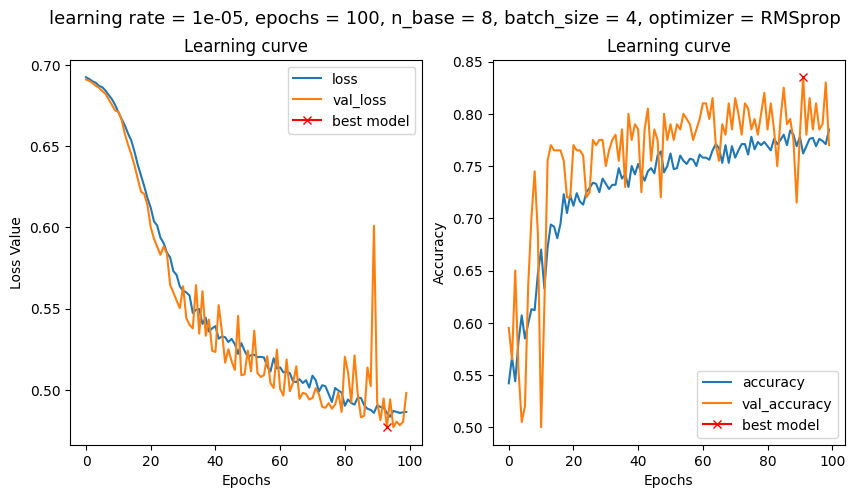

In [15]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer))

### Task 6F

In [14]:
#When using hinge instead of BinaryCrossEntropy as loss function 
y_test[y_test == 0] = -1
y_train[y_train == 0] = -1

In [23]:
epochs = 100

#optimum values
learning_rate = 1e-5
n_base = 8
batch_size = 4
optimizer = "Adam"
loss = "hinge"

clf_hist = model_trainer(learning_rate, epochs, n_base, batch_size, loss = loss, optimizer = optimizer,verbose = 0)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_64 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_65 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                 

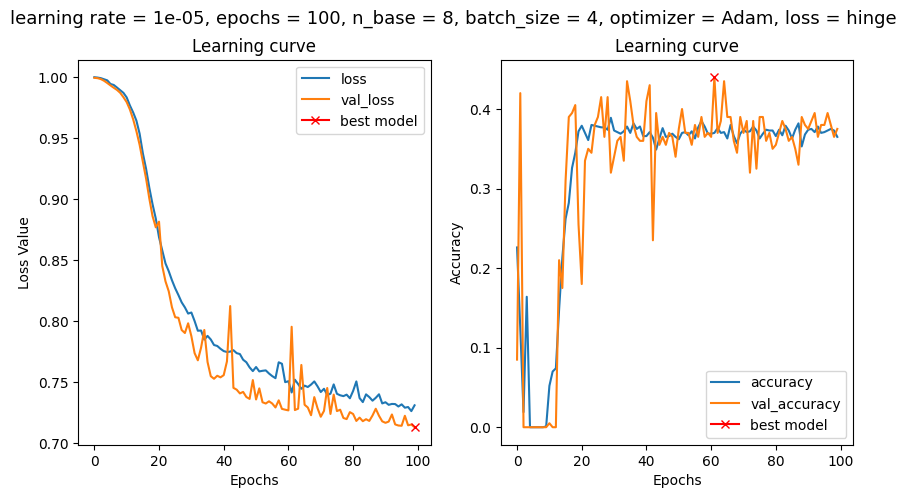

In [24]:
loss_accuracy_plot(clf_hist, "learning rate = {}, epochs = {}, n_base = {}, batch_size = {}, optimizer = {}, loss = {}".format(learning_rate,
                                                                                                        epochs,
                                                                                                        n_base,batch_size, 
                                                                                                        optimizer, loss))